In [24]:
import random
from collections import OrderedDict
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pydicom
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import map_coordinates

from helper import ViewCT, CtVolume
%matplotlib notebook

from time import time

In [22]:

def get_float_index(arr, index):
    shape = np.array(arr.shape)
    index = np.array(index)
    if not (np.all(index > np.zeros(index.shape)) and np.all(index < shape)):
        return


def two_vec_on_plane(normal_vector):
    if normal_vector[2] == 0:
        if normal_vector[1] == 0:
            return np.array([0, 1, 0]), np.array([0, 0, 1])
        elif normal_vector[0] == 0:
            return np.array([1, 0, 0]), np.array([0, 0, 1])
        else:
            y = random.uniform(0, 1)
            z = random.uniform(0, 1)

            vec1 = np.array([(-1) * np.dot(normal_vector[1:3], np.array([y, z])) / normal_vector[0], y, z])
            vec1 /= np.linalg.norm(vec1)

            x = random.uniform(0, 1)
            y = random.uniform(0, 1)
            vec2 = np.array([(-1) * np.dot(normal_vector[1:3], np.array([y, z])) / normal_vector[0], y, z])
            vec2 -= np.dot(vec1, vec2) * vec1
            vec2 /= np.linalg.norm(vec2)
    elif normal_vector[0] == 0 and normal_vector[1] == 0:
        return np.array([1, 0, 0]), np.array([0, 1, 0])
    else:
        x = random.uniform(0, 1)
        y = random.uniform(0, 1)

        vec1 = np.array([x, y, (-1) * np.dot(normal_vector[0:2], np.array([x, y])) / normal_vector[2]])
        vec1 /= np.linalg.norm(vec1)

        x = random.uniform(0, 1)
        y = random.uniform(0, 1)
        vec2 = np.array([x, y, (-1) * np.dot(normal_vector[0:2], np.array([x, y])) / normal_vector[2]])
        vec2 -= np.dot(vec1, vec2) * vec1
        vec2 /= np.linalg.norm(vec2)
    return vec1, vec2


def oblique_MPR(volume, spacing, point, normal_vector_plane, width, output_shape):
    u, v = two_vec_on_plane(normal_vector_plane)
    coords = (u[:, None, None] * np.linspace(width / -2.0, width / 2.0, output_shape[0])[None, :, None] +
              v[:, None, None] * np.linspace(width / -2.0, width / 2.0, output_shape[1])[None, None, :])

    idx = coords / spacing[(slice(None),) + (None,) * (coords.ndim - 1)] + point[:, None, None]
    new_data = map_coordinates(volume, idx, order=1, mode='constant', cval=0)
    return new_data


def get_centerlines(series_dir):
    ret = OrderedDict()

    for i, file in enumerate(sorted(glob(str(Path(series_dir).joinpath('*.dcm'))))):
        if i == 0:
            continue
        f = pydicom.read_file(file)
        try:
            vessel_name = f[0x00E11040].value
        except:
            continue

        try:
            center_infos = f[0x07A11012].value
        except:
            continue

        ret[vessel_name] = np.array(center_infos).reshape((-1, 9))

    return ret

def demo_centerlines_data(save=False):
    centerlines = get_centerlines(r'./CCTA/CCA results 75% 11 TI - 1109')
    fig = plt.figure()
    ax = Axes3D(fig)
    
    for vessel, points in centerlines.items():
        data = points[:, 0:3]
        ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=np.random.rand(3, ))
        
        
    # ax.scatter(data2[:, 0], data2[:, 1], data2[:, 2], color='red')
    if not save:
        plt.show()
    else:
        for angle in range(0, 360, 10):
            ax.view_init(30, angle)
            plt.savefig('coronary%d.png' % (angle,))
            # plt.pause(.001)

In [3]:
np.set_printoptions(formatter={'float_kind': lambda x: "%.2f" % x})

In [4]:
ct = CtVolume()
ct.load_image_data(r'./CCTA/HALF 75% 1.04s Axial 1.0 CTA-HALF CTA Sharp Cardiac LUNG 75% - 7')

0.007102251052856445


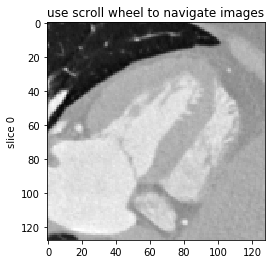

In [5]:
t = time()
plane = oblique_MPR(ct.data, ct.spacing, np.floor(np.array(ct.data.shape)/2.0),
                        np.array([1,1,1]), 128, (128, 128))
print(time()-t)
ViewCT(plane.reshape((1, 128, 128)))

In [6]:
centerlines = get_centerlines(r'./CCTA/CCA results 75% 11 TI - 1109')

<IPython.core.display.Javascript object>


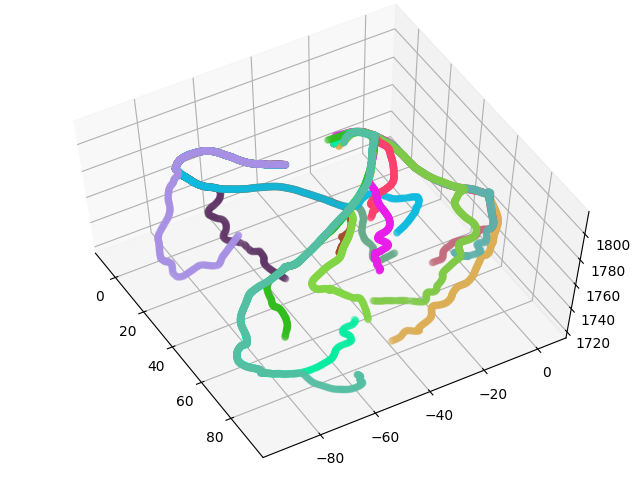

In [25]:
demo_centerlines_data()

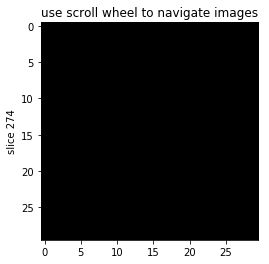

In [9]:
def curved_MPR(CtVolume, center_points):
    points = center_points[:, 0:3]
    ret = np.full((points.shape[0],30,30), -1024)
    for i in range(points.shape[0]):
        point1 = points[i]
        point2 = points[i-1] if i>0 else points[1]
        point1 = CtVolume.absolute_to_pixel_coord(point1, True)
        point2 = CtVolume.absolute_to_pixel_coord(point2, True)
        normal_vec = point1 - point2
        ret[i] = oblique_MPR(CtVolume.data, CtVolume.spacing, point1,
                        normal_vec, 30, (30, 30))
    return ret

ViewCT(curved_MPR(ct, centerlines['LAD']))